In [1]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm.notebook import tqdm
import torchvision.models as models
#from lion_pytorch import Lion


In [2]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    #os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.benchmark = True #включение cuDNN Autotuner
    #отключение отладок
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
seed_everything(42)
device = f"cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Чтение данных

In [3]:
#!gdown 1pczLG3MVuIErKmT0BVsxwlASScfUCYCw

In [4]:
#!gdown 161zAh0quBSGB9ydnHRFgEUAgSN2esZtn

In [5]:
x_data = np.load(r'I:\Хакатоны\Цифровой прорыв Сочи\train_dataset_train\train\y_smp_train.npy') #'/content/y_smp_train.npy'

In [6]:
x_data = np.reshape(x_data,(1000000, 3, 200))
x_data.shape

(1000000, 3, 200)

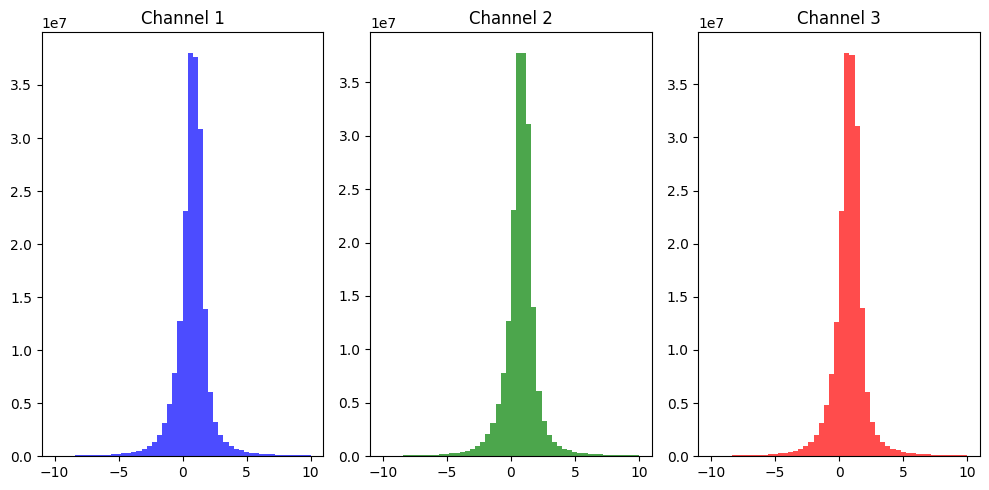

In [32]:
# Определение минимума и максимума для каждого канала
min_channel_1, max_channel_1 = np.min(x_data [:, 0, :]), np.max(x_data[:, 0, :])
min_channel_2, max_channel_2 = np.min(x_data[:, 1, :]), np.max(x_data[:, 1, :])
min_channel_3, max_channel_3 = np.min(x_data [:, 2, :]), np.max(x_data [:, 2, :])

# Построение гистограммы для каждого канала с указанием промежутка значений
plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.hist(channel_1.flatten(), bins=50, range=(-10, 10), color='blue', alpha=0.7)
plt.title('Channel 1')

plt.subplot(132)
plt.hist(channel_2.flatten(), bins=50, range=(-10, 10), color='green', alpha=0.7)
plt.title('Channel 2')

plt.subplot(133)
plt.hist(channel_3.flatten(), bins=50, range=(-10, 10), color='red', alpha=0.7)
plt.title('Channel 3')

plt.tight_layout()
plt.show()


In [7]:
y_data = np.load(r'I:\Хакатоны\Цифровой прорыв Сочи\train_dataset_train\train\pars_smp_train.npy') #'/content/pars_smp_train.npy'

In [8]:
y_data = np.reshape(y_data,(1000000, 15))
y_data.shape

(1000000, 15)

## Создание датасета для обучения

In [9]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        X = self.x_data[index]
        y = self.y_data[index]
        X = torch.tensor(X, dtype=torch.float32)

        # Полный путь к файлу изображения
        if self.transform:
            X = self.transform(X)
        return X, torch.from_numpy(y).to(torch.float32)

In [156]:
# нормализация данных
class Normalize(object):
    def __call__(self, sample):
        min_val = torch.min(sample)
        max_val = torch.max(sample)
        normalized = (sample - min_val) / (max_val - min_val + 1e-8)
        return torch.log(normalized)

    
data_transform = transforms.Compose([
 #   transforms.ToTensor(),
    Normalize()
])
custom_dataset = CustomDataset(x_data, y_data)

# Разделение на тренировочный и валидационный наборы с учетом дисбаланса классов
validation_split = 0.1
dataset_size = len(custom_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Получение индексов для разделения
indices = list(range(dataset_size))
random.shuffle(indices)  # Перемешиваем индексы перед разделением
train_indices, validation_indices = indices[:train_size], indices[train_size:]

## Создание функции обучения

In [11]:
# Quantile Loss (полезно в задачах квантильной регрессии
def quantile_loss(y_true, y_pred, q=0.5):
    e = y_true - y_pred
    loss = torch.max((q - 1) * e, q * e)
    return loss.mean()

In [128]:
def train_regression_model(model, num_epochs, train_loader, valid_loader, device, lr):
    model = model.to(device)
    criterion = nn.MSELoss().to(device)  # Используем MSE для задачи регрессии
    #criterion = quantile_loss # Используем MSE для задачи регрессии
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)
    #optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-2)
    #optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=1e-2)
    #optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=1e-2)
    #optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-2)

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0

        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs  = torch.mean(outputs, dim=2)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        valid_loss = 0.0
        total_samples = 0.0
        total_rmse = 0.0
        total_mape = 0.0

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                outputs  = torch.mean(outputs, dim=2)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
                total_samples += targets.size(0)
               
                #  вычисление RMSE
                rmse = torch.sqrt(loss)
                total_rmse += rmse.item()

                # вычисление MAPE
                absolute_error = torch.abs(outputs - targets)
                mape = torch.mean(absolute_error / targets) * 100
                total_mape += mape.item()

        epoch_duration = time.time() - start_time

        print(f"Epoch {epoch + 1} | Train_Loss: {running_loss / len(train_loader):.4f} | Valid_Loss: {valid_loss / len(valid_loader):.4f} | RMSE: {total_rmse / len(valid_loader):.4f} | MAPE: {total_mape / len(valid_loader):.4f}% | Time: {epoch_duration:.2f} seconds")

## Создание архитектуры нейронной сети

In [13]:
class Simple(nn.Module):
    def __init__(self, params=15):
        super(Simple, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Нормализация
        self.batchnorm = nn.BatchNorm1d(128)
        # Дропаут
        self.dropout = nn.Dropout(0.5)  # 0.5 - вероятность отключения нейрона
        
        # Полносвязные слои
        self.fc1 = nn.Linear(128*200, 1024)
        self.fc2 = nn.Linear(1024, 15*201)  # 15*6 = 90
        
    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        
        # Нормализация и дропаут
        x = self.batchnorm(x)
        x = self.dropout(x)
        
        # Решейп для подачи в полносвязные слои
        x = x.view(x.size(0), -1)
        
        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Решейп обратно к размерности (-1, 15, 6)
        x = x.view(-1, 15, 201) #201 Score = 0.674089 model_CNN_CB_4.pth
        return x

# Обучени модели

In [102]:
# инициализация модели
model = Simple()
#загрузка весов модели
model.load_state_dict(torch.load('model_CNN_CB_5.pth'))


<All keys matched successfully>

In [157]:
# Обучение модели
num_epochs = 1000
lr = 0.0001
batch_size = 4096

In [158]:
# Создание DataLoader для тренировочного и валидационного наборов 
train_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_indices, pin_memory=True)
valid_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=validation_indices, pin_memory=True)

In [ ]:
train_regression_model(model, num_epochs, train_loader, valid_loader, device, lr)

Epoch 1 | Train_Loss: 0.0175 | Valid_Loss: 0.0113 | RMSE: 0.1064 | MAPE: 16.4046% | Time: 52.79 seconds
Epoch 2 | Train_Loss: 0.0172 | Valid_Loss: 0.0113 | RMSE: 0.1063 | MAPE: 16.4042% | Time: 52.95 seconds
Epoch 3 | Train_Loss: 0.0171 | Valid_Loss: 0.0117 | RMSE: 0.1083 | MAPE: 16.6026% | Time: 53.40 seconds
Epoch 4 | Train_Loss: 0.0170 | Valid_Loss: 0.0117 | RMSE: 0.1080 | MAPE: 16.5676% | Time: 53.16 seconds
Epoch 5 | Train_Loss: 0.0168 | Valid_Loss: 0.0124 | RMSE: 0.1112 | MAPE: 16.7374% | Time: 53.30 seconds
Epoch 6 | Train_Loss: 0.0167 | Valid_Loss: 0.0122 | RMSE: 0.1105 | MAPE: 16.6683% | Time: 53.23 seconds
Epoch 7 | Train_Loss: 0.0166 | Valid_Loss: 0.0122 | RMSE: 0.1106 | MAPE: 16.7734% | Time: 53.22 seconds
Epoch 8 | Train_Loss: 0.0166 | Valid_Loss: 0.0125 | RMSE: 0.1120 | MAPE: 16.6888% | Time: 53.70 seconds
Epoch 9 | Train_Loss: 0.0165 | Valid_Loss: 0.0123 | RMSE: 0.1108 | MAPE: 16.7170% | Time: 53.73 seconds
Epoch 10 | Train_Loss: 0.0164 | Valid_Loss: 0.0127 | RMSE: 0.112

# Submisson

In [ ]:
#!gdown 1eIS3ZVhPTs3zQE91sTpRNvuDVFIyqYX0

In [138]:
test_data = np.load(r'I:\Хакатоны\Цифровой прорыв Сочи\test_dataset_test\test\y_smp_test.npy') #'/content/y_smp_test.npy
test_data = np.reshape(test_data,(100000, 3, 200))
test_data.shape

(100000, 3, 200)

In [139]:
test_data = CustomDataset(test_data, test_data)
batch_size = 10000
num_workers = torch.multiprocessing.cpu_count()  # Использование всех доступных ядер
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [140]:
sub = torch.empty(1, 15, 201)
with torch.no_grad():
              model.eval()
              for inputs, _ in tqdm(test_loader):
                    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
                    outputs = model(inputs).to('cpu')
                    sub = torch.cat((sub, outputs), dim=0)


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_9120\262521371.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)


In [141]:
#сохраняем веса модели
model_CNN =  model.to('cpu')
torch.save(model_CNN.state_dict(), 'model_CNN_CB_9.pth')

In [142]:
print(sub[1:].shape)

torch.Size([100000, 15, 201])


In [143]:
# Переводим в numpy
numpy_array = sub[1:].numpy()

In [144]:
test_predictions_agregate = np.empty((100000, 15, 6))
test_predictions_agregate[:] = np.nan
for idx_row in tqdm(range(100000)):
    for idx_model in range(15):
        obj = numpy_array[idx_row, idx_model]
        test_predictions_agregate[idx_row, idx_model] = [np.nanmean(obj), np.nanquantile(obj, 0.1), np.nanquantile(obj, 0.25), np.nanquantile(obj, 0.5), np.nanquantile(obj, 0.75), np.nanquantile(obj, 0.90)]
test_predictions_agregate.shape

  0%|          | 0/100000 [00:00<?, ?it/s]

(100000, 15, 6)

In [145]:
test_predictions_agregate[0][1]

array([2.46038103, 2.4290626 , 2.44198656, 2.46219182, 2.47714114,
       2.48999   ])

In [146]:
file_path = r'C:\Users\user\Downloads\submission\result_9.npy'
np.save(file_path, test_predictions_agregate)